# Estimating the value of $\pi$ using a Monte Carlo technique 

### Authors: 
- Troels C. Petersen (Niels Bohr Institute)
- Christian Michelsen (Niels Bohr Institute)

### Date:    
- 28-12-2019 (latest update)
***
The program picks random points in the area $[-1,1] \times [-1,1]$, and determines which fraction of these are within the unit circle. This in turn gives a measure of $\pi$ with associated statistical uncertainty. Performing such "experiments" many times not only gives the value of $\pi$, but also a feel for the use of Monte Carlo, and experience in calculating averages, RMSs, and the error on these.
The first part of the program is mostly for illustration, while the exercise is question 4 on using this in higher dimension problems.

For more information see:
- P. R. Bevington: page 75-78

***

First we import the needed modules:

In [1]:
import numpy as np                                     # Matlab like syntax for linear algebra and functions
import matplotlib.pyplot as plt                        # Plots and figures like you know them from Matlab
import seaborn as sns                                  # Make the plots nicer to look at
from iminuit import Minuit                             # The actual fitting tool, better than scipy's
import sys                                             # Modules to see files and folders in directories
from scipy import stats

In [2]:
sys.path.append('../../../External_Functions')
from ExternalFunctions import Chi2Regression, BinnedLH, UnbinnedLH
from ExternalFunctions import nice_string_output, add_text_to_ax   # Useful functions to print fit results on figure

and define the parameters of the program:

In [3]:
save_plots = True         # Determining if plots are saved or not
r = np.random
r.seed(42)

# Set parameters:
N_experiments = 100       # Number of "experiments" determining pi
N_points      = 2000     # Number of points per experiment in determining pi

pi_true = np.pi

## Loop over process:

In [4]:
pi_dist    = np.zeros(N_experiments)
hit_dist_x = np.zeros(N_points)
hit_dist_y = np.zeros(N_points)

for iexp in range(N_experiments):

    # Fill random numbers into square, and see how many are inside unit circle:
    hit_dist_x = r.uniform(-1, 1, N_points)
    hit_dist_y = r.uniform(-1, 1, N_points)
    Nhit = np.sum(hit_dist_x**2 + hit_dist_y**2 < 1)
    
    # Calculate the fraction of points within the circle and its error:
    f  = Nhit / N_points
    sf = np.sqrt(f * (1.0-f) / N_points)         # Remind yourself the uncertainty on a fraction n/N!!!

    # From this we can get pi and its error, and save it:
    pi_estm  = 4.0 * f
    pi_error = 4.0 * sf
    pi_dist[iexp] = pi_estm

    # Print first couple of pi measurements:
    if (iexp < 5) :
        print(f"{iexp:2d}. pi estimate:   {pi_estm:7.4f} +- {pi_error:6.4f}")

 0. pi estimate:    3.1400 +- 0.0367
 1. pi estimate:    3.1680 +- 0.0363
 2. pi estimate:    3.1460 +- 0.0367
 3. pi estimate:    3.1040 +- 0.0373
 4. pi estimate:    3.1400 +- 0.0367


In [5]:
if (N_experiments > 1):
    pi_mean = pi_dist.mean()
    pi_std = pi_dist.std(ddof=1)
    pi_standard_error = pi_std / np.sqrt(N_experiments)
    print(f"The {N_experiments:d} experiments yields: pi = {pi_mean:7.5f} +- {pi_standard_error:7.5f}     (std = {pi_std:5.3f})")
    print(f"and the agreement with the true value of pi is: {(pi_mean - pi_true) / pi_standard_error:6.2f} sigma")
else :
    print("Since only one experiment was done, no average and RMS can be calculated.")

The 100 experiments yields: pi = 3.14332 +- 0.00370     (std = 0.037)
and the agreement with the true value of pi is:   0.47 sigma


## Plot the histograms:

Distribution of points from one experiment:

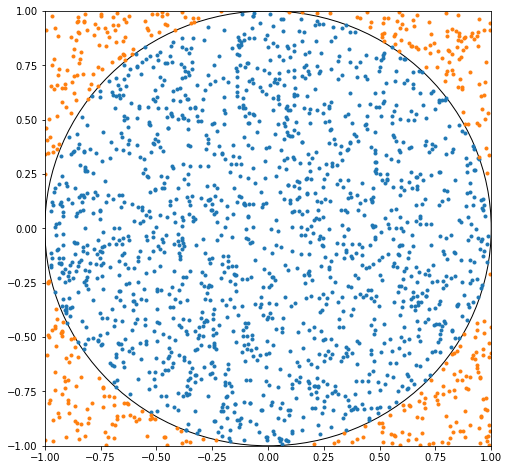

In [6]:
fig1, ax1 = plt.subplots(figsize=(8, 8))    

# Make mask of points inside vs outside the circle:
mask_inside = hit_dist_x**2 + hit_dist_y**2 < 1
mask_outside = ~mask_inside

# Make scatter plot of points:
ax1.plot(hit_dist_x[mask_inside], hit_dist_y[mask_inside], '.')
ax1.plot(hit_dist_x[mask_outside], hit_dist_y[mask_outside], '.')
ax1.set(xlim=(-1, 1), ylim=(-1,1))

# Add circle to plot:
ax1.add_artist(plt.Circle((0, 0), 1, color='k', fill=False))

if save_plots: 
    fig1.savefig("HitDist.pdf")

### Distribution of resulting estimates for pi:

Fit the distribution of pi estimates to get the mean and standard deviation:

In [7]:
def ext_gauss_pdf(x, N, mu, sigma):
    return N / np.sqrt(2*np.pi) / sigma * np.exp(-0.5 * (x-mu)**2 / sigma**2)

In [8]:
fit_object = UnbinnedLH(ext_gauss_pdf, pi_dist, extended=True) 
minuit = Minuit(fit_object, print_level=0, pedantic=False, N=100, mu=3.14, sigma=0.1)
minuit.migrad();
if (not minuit.get_fmin().is_valid) :                                   # Check if the fit converged!
    print("  WARNING: The unbinned likelihood fit DID NOT converge!!!")

In [9]:
minuit_output = [minuit.get_fmin(), minuit.get_param_states()]       # Save the output parameters in case needed
for name in minuit.parameters:
    print("  Unbinned LLH Fit result: {0} = {1:.5f} +/- {2:.5f}".format(name, minuit.values[name], minuit.errors[name]))

  Unbinned LLH Fit result: N = 104.18352 +/- 10.67187
  Unbinned LLH Fit result: mu = 3.14340 +/- 0.00465
  Unbinned LLH Fit result: sigma = 0.04139 +/- 0.00442


Plot the distribution of $\pi$ estimates and fit it with an unbinned likelihood fit:

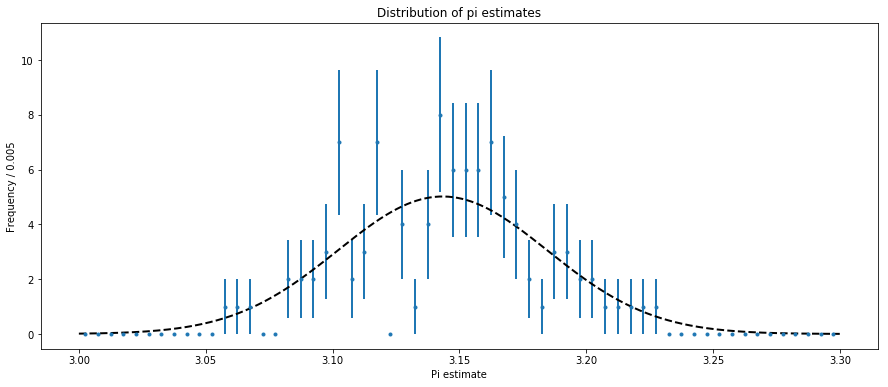

In [10]:
Nbins = 60
xmin, xmax = 3.0, 3.30
binwidth = (xmax - xmin) / Nbins

fig2, ax2 = plt.subplots(figsize=(15, 6))
y, bin_edges = np.histogram(pi_dist, bins=Nbins, range=(xmin, xmax))
x = 0.5*(bin_edges[1:] + bin_edges[:-1])
sy = np.sqrt(y)      # This is the standard for histograms - bin entries are Poisson distributed!
hist_data = ax2.errorbar(x, y, sy, fmt='.', linewidth=2, label="Data")
ax2.set(xlabel="Pi estimate", ylabel = "Frequency / 0.005", title = "Distribution of pi estimates")
fig2

# Plot fit result on top of histograms:
x_ulfit = np.linspace(xmin, xmax, 1000)                                    # Create the x-axis for the plot of the fitted function
y_ulfit = binwidth * ext_gauss_pdf(x_ulfit, *minuit.args)
ax2.plot(x_ulfit, y_ulfit, '--', color='black', linewidth=2, label='Fit (unbinned LLH)')

if save_plots: 
    fig2.savefig("DistPiEstimates.pdf")

### Try determining the formula for the hyper volume of an N-dimensional ball:

For illustration, I will just start with Ndim = 3, for which the result is know. It is always good to test a method on a known case, before applying it to a (probably harder) unknown case.

In [22]:
N_points = 20000000               # Fast computers breed lazy programmers! So don't be shy here :-)
hit_dist_x = np.zeros(N_points)
hit_dist_y = np.zeros(N_points)
hit_dist_z = np.zeros(N_points)

# Fill random numbers into a unit cube, and see how many are inside unit ball:
hit_dist_x = r.uniform(-1, 1, N_points)
hit_dist_y = r.uniform(-1, 1, N_points)
hit_dist_z = r.uniform(-1, 1, N_points)
Nhit = np.sum(hit_dist_x**2 + hit_dist_y**2 + hit_dist_z**2 < 1)
    
# Calculate the fraction of points within the circle and its error:
f3  = Nhit / N_points
sf3 = np.sqrt(f3 * (1.0-f3) / N_points)

# From this and KNOWING PI we can now estimate what factor should go in front of the pi * r^3,
# as the fraction of points inside the unit ball should correspond to the ball volume compared
# to the cube volume:   f3 = V_ball / V_cube = factor3D * pi * r^3 / V_cube   ==>  factor3D = f3 / pi * V_cube
factor3D_estm  = f3 / np.pi * 8.0
factor3D_error = sf3 / np.pi * 8.0

print(f"  3D case: factor estimate = {factor3D_estm:8.5f} +- {factor3D_error:7.5f}")

  3D case: factor estimate =  1.33353 +- 0.00028


***

First acquaint yourself with the program, and make sure that you understand what the parameters `N_experiment` and `N_points` refer to! Also, before running the program,
calculate what precision you expect on pi in each experiment, when using the number of points chosen in the program (i.e. 2000 points).

Then, run the program, and then take a look at the result... which requires that you fill in the calculations yourself!

# Initial questions:

0. Plot the distribution of $\pi$ values obtained.

1. Try to run 100 experiments with 2000 points in each. What is the approximate uncertainty on $\pi$ in each experiment? Does that fit, what you calculated before running the program? What is the uncertainty on the AVERAGE of all 100 experiments? 

_Example solution 1_: Before running the program, we could estimate $\sigma(\pi)_{2000 points}$ using the "fact" that $\pi$ is approximately 3 and the unit square has area 4. We should thus get the fraction of points inside the circle to be 3/4 and $\sigma(\pi)_{2000 points} = 4 * \sqrt{3/4 * (1-3/4) / N} = 0.039$. In reality one gets 0.0367 and a width of the $\pi$ estimates of $0.041 \pm 0.004$, all in good agreement.
The uncertainty on the average is of course much lower, as we combine 100 experiments, and we should thus divide by $\sqrt(100) = 10$, which gives us around 0.004.


2. How do you expect the values of $\pi$ to distribute themselves? And is this the case in reality?

_Example solution 2_: Since each $\pi$ estimate is the result of 2000 attempts each with $\pi$/4 chance of succes, the distribution is in principle binomial. Of course with this statistics, it resembles a Gaussian very much. As can be observed.


3. Does it make any difference on the precision of the final $\pi$ value, whether you make many experiments with few points, or one experiment with many points, as long as the product of `N_experiment` $\times$ `N_points` remains constant?

_Example solution 3_: No! The only reason one would at all divide into two is to cross check uncertainties. Once these are trusted, one should simply calculate $\pi$ from one long list of points in the square.


# The real exercise question:

4. Now try to use this method in three dimensions to estimate the constant in front of the $r^3$ expression for the volume. Do you get $\frac{4}{3} \pi$?
    Increase the dimensionality (say up to 10), and see if you can figure out the constants needed to calculate the hyper-volumes!

    HINT: I'll reveal that for `N_dim` of 4 and 5, the constant contains $\pi^2$ and some simple rational fraction, while for `N_dim` 6 and 7, it contains $\pi^3$ and a
      rational fraction.
      
_Example solution 4_: A solution can be seen above for 3D, which can easily be expanded to 4D. However, it does not expand easily to N dimensions... that you will have to do yourself!